# Load Sentinel-3 data from the CDSE STAC catalog

This notebook shows an example how to load Sentinel-3 data from the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?.language=en).

### Setup
In order to run this notebook you may install [`xcube_stac`](https://github.com/xcube-dev/xcube-stac), following the [README](../../README.md).

The data can be accessed via S3, where key and secret can be obtained following the [CDSE access documentation to EO data via S3](https://documentation.dataspace.copernicus.eu/APIs/S3.html#generate-secrets). The store object will receive the key and secret upon initialization, as demonstrated below.

Now, we first import everything we need:

In [1]:
%%time
import itertools

import matplotlib.pyplot as plt
import xarray as xr
from xcube.core.store import new_data_store, get_data_store_params_schema

CPU times: user 3.45 s, sys: 321 ms, total: 3.77 s
Wall time: 1.98 s


In [2]:
xr.set_options(display_expand_attrs=False)

Next store the credentials in a dictionary. 

In [3]:
credentials = dict(
    key="xxx",
    secret="xxx",
)

There are two [data stores](https://xcube.readthedocs.io/en/latest/dataaccess.html#data-store-framework) available for the [CDSE STAC API](https://browser.stac.dataspace.copernicus.eu/?language=en):

- **`stac-cdse-ardc`**: Allows you to open multiple STAC items and assemble them into a 3D spatiotemporal data cube.
- **`stac-cdse`**: Enables you to open individual STAC items.

---
## Data store to access spatiotemporal anaylsis-ready data cubes 

In the following, we will first demonstrate how to use the `stac-cdse-ardc` store. To view the parameters to initialize the data store instance, execute the following cell. 

> **Note:**  
> Access requires your S3 `key` and `secret`.

In [4]:
%%time
store_params = get_data_store_params_schema("stac-cdse-ardc")
store_params

CPU times: user 646 ms, sys: 78.7 ms, total: 725 ms
Wall time: 725 ms


In [5]:
%%time
store = new_data_store("stac-cdse-ardc", **credentials)

CPU times: user 11.7 ms, sys: 0 ns, total: 11.7 ms
Wall time: 132 ms


The following cell shows the available data IDs for the analysis-ready datacube mode. The data IDs point to a STAC collections.

In [6]:
%%time
data_ids = store.list_data_ids()
data_ids

CPU times: user 22 μs, sys: 3 μs, total: 25 μs
Wall time: 27.7 μs


['sentinel-2-l2a', 'sentinel-2-l1c', 'sentinel-3-syn-2-syn-ntc']

Below, the parameters for the `open_data` method can be viewed for aspecific data ID.

In [7]:
%%time
open_params = store.get_open_data_params_schema("sentinel-3-syn-2-syn-ntc")
open_params

CPU times: user 10.8 ms, sys: 3.84 ms, total: 14.6 ms
Wall time: 14 ms


The store supports the collection `sentinel-2-l1c` and `sentinel-2-l2a`. We first get Sentinel-2 Level-1C data by assigning the `data_id` to `"sentinel-2-l1c"`. 

In [8]:
%%time
ds = store.open_data(
    data_id="sentinel-3-syn-2-syn-ntc",
    bbox=[8, 52, 12, 55],
    time_range=["2020-07-31", "2020-08-01"],
    spatial_res=300 / 111320, # meter in degree
    crs="EPSG:4326",
    asset_names=["syn_Oa01_reflectance", "syn_Oa02_reflectance"],
)
ds

CPU times: user 14.4 s, sys: 4.44 s, total: 18.8 s
Wall time: 1min 52s


<xarray.Dataset> Size: 53MB
Dimensions:       (time: 2, lat: 1115, lon: 1486)
Coordinates:
  * lat           (lat) float64 9kB 55.0 55.0 55.0 54.99 ... 52.01 52.0 52.0
  * lon           (lon) float64 12kB 8.0 8.003 8.005 8.008 ... 12.0 12.0 12.0
  * time          (time) datetime64[ns] 16B 2020-07-31T10:10:08.191012 2020-0...
Data variables:
    SDR_Oa01      (time, lat, lon) float32 13MB dask.array<chunksize=(1, 1115, 1486), meta=np.ndarray>
    SDR_Oa01_err  (time, lat, lon) float32 13MB dask.array<chunksize=(1, 1115, 1486), meta=np.ndarray>
    SDR_Oa02      (time, lat, lon) float32 13MB dask.array<chunksize=(1, 1115, 1486), meta=np.ndarray>
    SDR_Oa02_err  (time, lat, lon) float32 13MB dask.array<chunksize=(1, 1115, 1486), meta=np.ndarray>
Attributes: (3)

We can plot the spectral band 0 from the  OLCI Instrument as an example.

CPU times: user 1.06 s, sys: 169 ms, total: 1.23 s
Wall time: 4.85 s


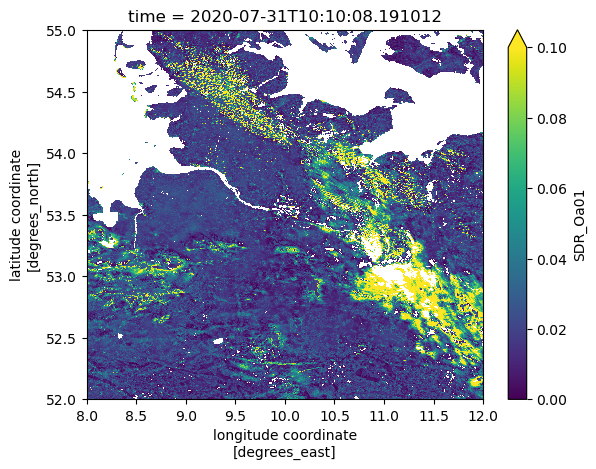

In [9]:
%%time
ds.SDR_Oa01.isel(time=-2).plot(vmin=0., vmax=0.1)

----
## Data store to access single observations
Now, we initiate the data store to access each STAC item representing one observation tile. 

In [10]:
%%time
store_params = get_data_store_params_schema("stac-cdse")
store_params

CPU times: user 84 μs, sys: 0 ns, total: 84 μs
Wall time: 89.6 μs


To initialize the CDSE STAC data store, execute the following cell.

In [11]:
%%time
store = new_data_store("stac-cdse", **credentials)

CPU times: user 7.57 ms, sys: 2.67 ms, total: 10.2 ms
Wall time: 146 ms


Below, the parameters for the `open_data` method can be viewed.

In [12]:
%%time
open_params = store.get_open_data_params_schema()
open_params

CPU times: user 33 μs, sys: 8 μs, total: 41 μs
Wall time: 46 μs


If we specify the data ID, we obtain more precise parameters for opening and accessing that specific dataset.

In [13]:
data_id = (
    "collections/sentinel-3-syn-2-syn-ntc/items/S3B_SY_2_SYN____20250706T233058_"
    "20250706T233358_20250708T043306_0179_108_258_3420_ESA_O_NT_002"
)
store.get_open_data_params_schema(data_id=data_id)

We can now open the data set associated with the data ID. Note that first we do not apply any rectification. Thus the data is shown on the irregular native grid. 

In [14]:
%%time
ds = store.open_data(
    data_id,
    apply_rectification=False,
    add_error_bands=False
)
ds

CPU times: user 737 ms, sys: 394 ms, total: 1.13 s
Wall time: 14 s


<xarray.Dataset> Size: 2GB
Dimensions:   (y: 4091, x: 4865)
Coordinates:
    lon       (y, x) float64 159MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    lat       (y, x) float64 159MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables: (12/26)
    SDR_S1N   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S1O   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S2N   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S2O   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S3N   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S3O   (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    ...        ...
    SDR_Oa11  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa12  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa16  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa17  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21  (y, x) float32 80MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
Attributes: (15)

CPU times: user 1.75 s, sys: 949 ms, total: 2.7 s
Wall time: 26.3 s


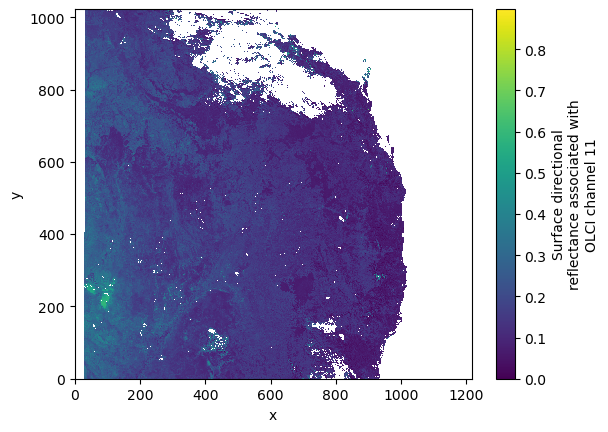

In [15]:
%%time
ds.SDR_Oa11[::4, ::4].plot()

In the next step we show the dataset on a regular grid, where the [xcube's rectification algorithm](https://xcube.readthedocs.io/en/latest/rectify.html) is applied. Note that showning the data on a regular grid is the default. 

In [16]:
%%time
ds = store.open_data(data_id)
ds

CPU times: user 39.4 s, sys: 7.73 s, total: 47.1 s
Wall time: 38.2 s


<xarray.Dataset> Size: 11GB
Dimensions:       (lat: 6739, lon: 8025, bnds: 2)
Coordinates:
  * lat           (lat) float64 54kB -21.05 -21.05 -21.06 ... -34.53 -34.53
  * lon           (lon) float64 64kB 140.9 140.9 140.9 ... 157.0 157.0 157.0
    lon_bnds      (lon, bnds) float64 128kB 140.9 140.9 140.9 ... 157.0 157.0
    lat_bnds      (lat, bnds) float64 108kB -21.05 -21.05 ... -34.53 -34.53
Dimensions without coordinates: bnds
Data variables: (12/52)
    SDR_S1N       (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S1N_err   (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S1O       (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S1O_err   (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S2N       (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_S2N_err   (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    ...            ...
    SDR_Oa17      (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa17_err  (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18      (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa18_err  (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21      (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
    SDR_Oa21_err  (lat, lon) float32 216MB dask.array<chunksize=(1023, 1217), meta=np.ndarray>
Attributes: (15)

CPU times: user 29.9 s, sys: 6.77 s, total: 36.7 s
Wall time: 10.8 s


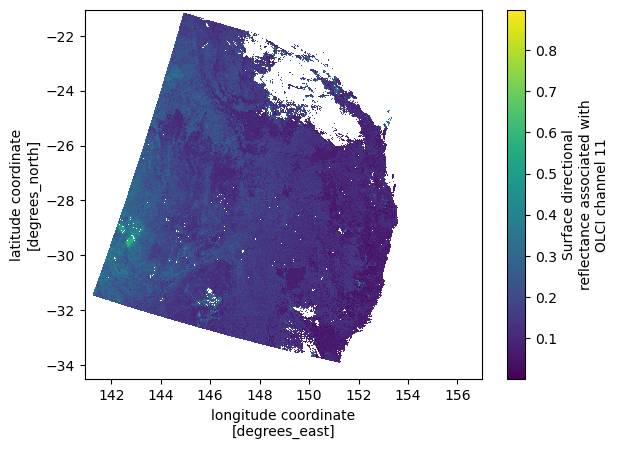

In [17]:
%%time
ds.SDR_Oa11[::4, ::4].plot()